# Лабораторная работа №2
Пресняцкий Виктор, гр. 956241, вариант 5

## Прогнозирование значений процесса с помощью нейронных сетей

In [2]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

### Часть 1.

In [3]:
K = 5  # number of previous values
D_t = 0.0001  # delta t interval
interval_T = (0, 5)

In [4]:
def f(x):
    return math.sin(2 * math.pi * x)


def generate_time_series(delta_t, interval_t, func=f):
    t1, t2 = interval_t
    return [func(x) for x in np.arange(t1, t2, delta_t)]


def transofrm_seq_to_dataset(sequence, k):
    len_seq = len(sequence) - k
    X = np.zeros((len_seq, k), dtype=np.float)
    y = np.zeros(len_seq, dtype=np.float)
    
    for i in range(len_seq):
        X[i, :] = sequence[i:i + k] # 
        y[i] = sequence[i + k]
    
    X = X.reshape((len_seq, k, 1))
    y = y.reshape((len_seq, 1))
    
    return X, y

Генерируем обучающую и тестовую выборку.

In [5]:
train_seq = generate_time_series(D_t, interval_t=interval_T)
train_time = np.arange(*interval_T, D_t)[K:]
X_train, y_train = transofrm_seq_to_dataset(train_seq, k=K)

d_interval = interval_T[1] - interval_T[0]
interval_T_test = [interval_T[0] + d_interval, interval_T[1] + d_interval]
test_time = np.arange(*interval_T_test, D_t)[K:]
test_seq = generate_time_series(D_t, interval_T_test)

x_series = np.arange(*interval_T_test, 0.05)
y_real_values = [f(x) for x in x_series]

X_test, y_test = transofrm_seq_to_dataset(test_seq, k=K)

In [6]:
def plot_prognoz_signal_chart(preds):
    plt.figure(figsize=(10,10))
    plt.plot(test_time, preds, color='blue', linewidth=0.5)
    plt.scatter(x_series, y_real_values, color='green', marker='*', s=50)
    plt.ylabel("Prognoz - Signal*")
    plt.xlabel("Time")
    plt.show()

In [7]:
def plot_error_chart(preds):
    plt.figure(figsize=(10, 10))
    plt.plot(test_time, preds - y_test, linewidth=0.5)
    plt.ylabel("Error")
    plt.xlabel("Time")
    plt.ylim(-0.1, 0.1)
    plt.show()

In [8]:
def show_history(history):
    epochs = len(history.history['loss'])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 10))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.show()

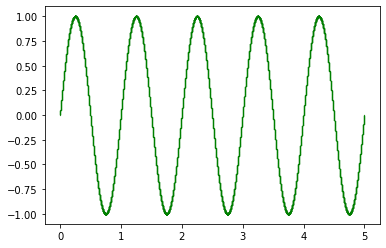

In [9]:
plt.scatter(train_time, y_train, color='green', s=0.01)
plt.show()

Строим полносвязную нейронную сеть с тремя слоями: 32 нейрона на первом слое, 16 нейронов на втором и 1 на выходном слое.

In [10]:
seq_model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape=(K, 1), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Flatten(input_shape=(K, 16)),
    keras.layers.Dense(1, activation='tanh'),
]) 

seq_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mae')
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5, 32)             64        
_________________________________________________________________
dense_1 (Dense)              (None, 5, 16)             528       
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = seq_model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 1s 788us/step - loss: 0.0306 - val_loss: 0.0130
Epoch 2/10
1407/1407 [==============================] - 1s 695us/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/10
1407/1407 [==============================] - 1s 682us/step - loss: 0.0043 - val_loss: 0.0038
Epoch 4/10
1407/1407 [==============================] - 1s 680us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 5/10
1407/1407 [==============================] - 1s 684us/step - loss: 0.0032 - val_loss: 0.0044
Epoch 6/10
1407/1407 [==============================] - 1s 709us/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/10
1407/1407 [==============================] - 1s 691us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/10
1407/1407 [==============================] - 1s 695us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/10
1407/1407 [==============================] - 1s 706us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 10/10
1407/1407 [==============================] - 1s 700u

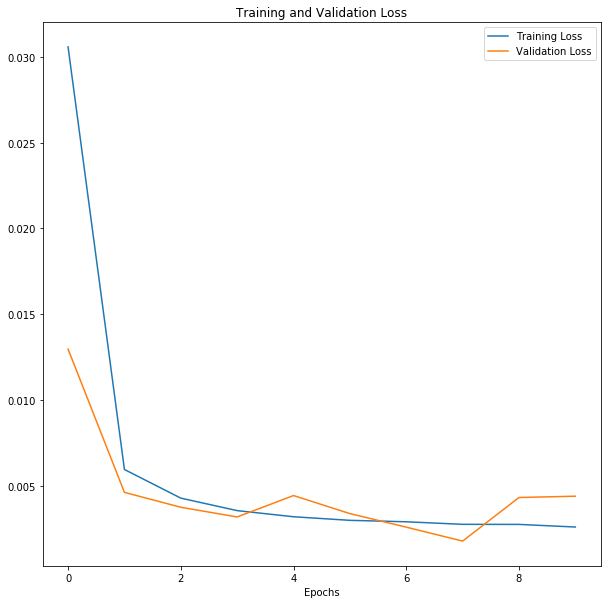

In [12]:
show_history(history)

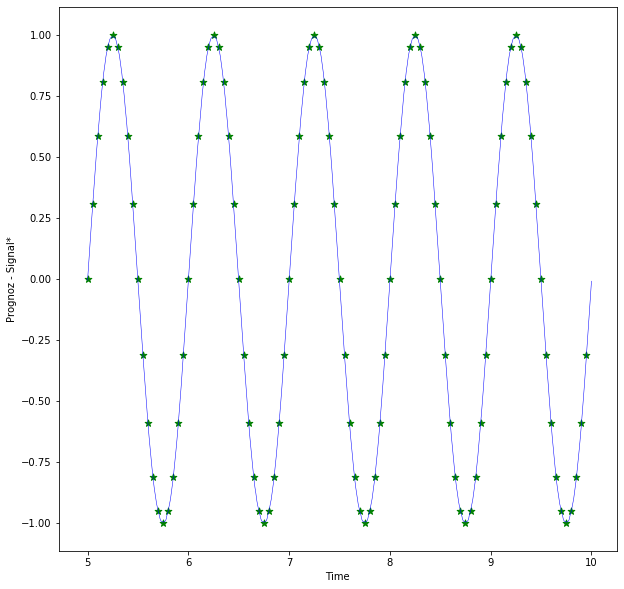

In [13]:
seq_predictions = seq_model.predict(X_test)
plot_prognoz_signal_chart(seq_predictions)

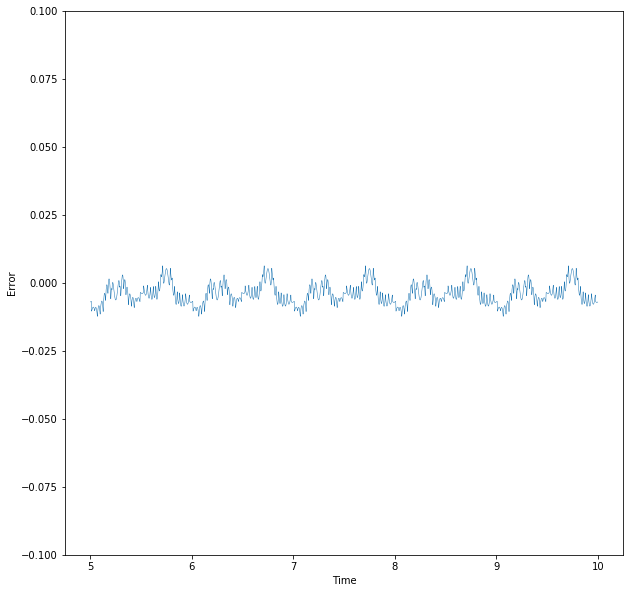

In [14]:
plot_error_chart(seq_predictions)

Строим простую рекуррентную нейронную сеть с 15 юнитами.

In [15]:
rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(units=15, input_shape=(K, 1)),
    keras.layers.Dense(1),
])

rnn_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mae')
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 15)                255       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [18]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 2/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 6.6549e-04
Epoch 4/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 9.3072e-04
Epoch 5/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 4.4217e-04
Epoch 6/10
1407/1407 [==============================] - 2s 1ms/step - loss: 0.0011 - val_loss: 6.5186e-04
Epoch 7/10
1407/1407 [==============================] - 2s 1ms/step - loss: 9.5847e-04 - val_loss: 0.0015
Epoch 8/10
1407/1407 [==============================] - 2s 1ms/step - loss: 9.5392e-04 - val_loss: 6.4875e-04
Epoch 9/10
1407/1407 [==============================] - 2s 1ms/step - loss: 9.5218e-04 - val_loss: 7.9164e-04
Epoch 10/10
1407/1407 [=======================

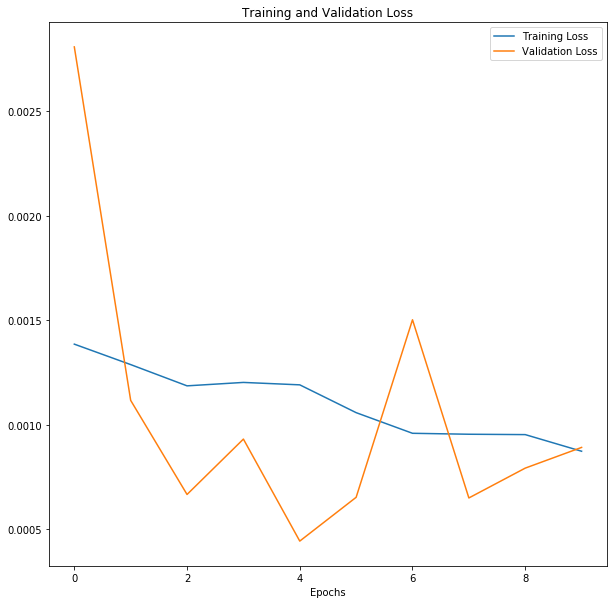

In [19]:
show_history(rnn_history)

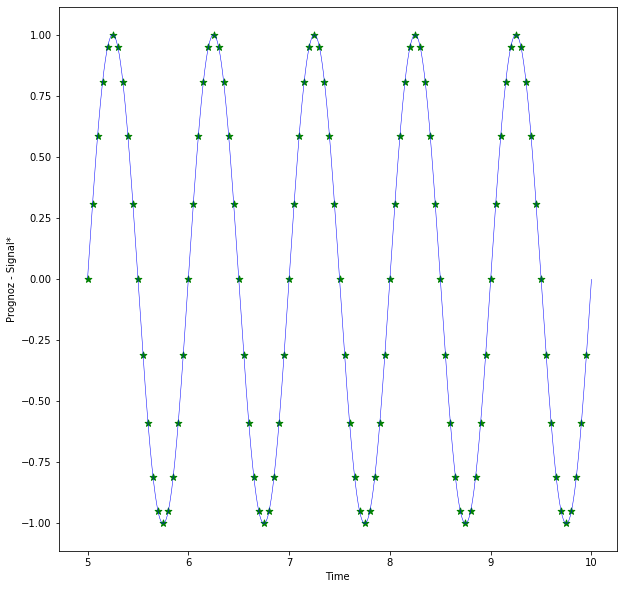

In [20]:
rnn_predictions = rnn_model.predict(X_test)
plot_prognoz_signal_chart(rnn_predictions)

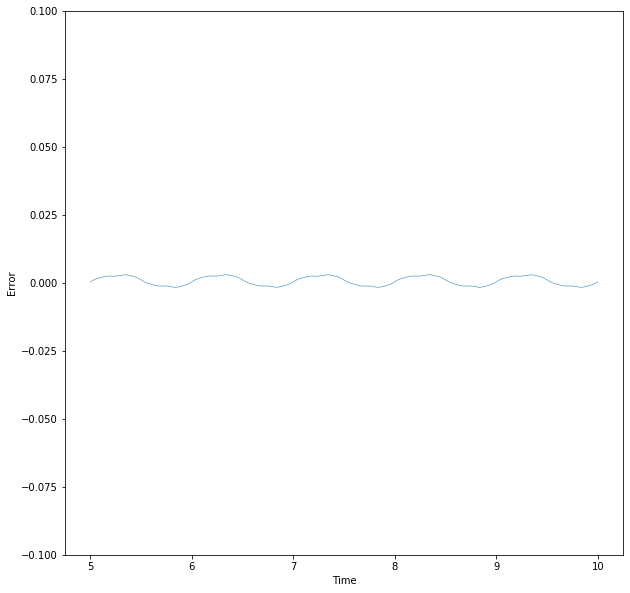

In [21]:
plot_error_chart(rnn_predictions)

Как видим, разброс ошибок рекуррентной сети меньше. Значит она справляется с данной задачей эффективнее. Гипперпараметры сетей, K и D_t подбирались таким образом, чтобы минимизировать ошибку. Очевидно, что чем меньше D_t, тем больше данных получается в обущающей выборке, тем точнее обучается сеть.

### Часть 2.

Имеется набор данных наблюдений температуры, начиная с 1833 г.,  города Jena институтом им.Макса Планка: минимальная, средняя, макимальная.
 Необходимо построить нейронную сеть net, позволяющую прогнозировать будущее значение показаний температуры на день вперед по предыдущим значениям температуры за k дней. Получить вектор y спрогнозированных выходов путем моделирования полученной сети net.
Набор данных разделить на обучающую и тестовую выборки в соотношении 0.75 к 0.25.
Нейронную сеть net разработать на основе трех архитектур:
- полносвязная сеть прямого распространения (слой Dence);
- LSTM рекуррентная сеть (слой LSTM);
- GRU рекуррентная сеть (слой GRU).
Работу выполнить по схеме и указаниям первой части.

Согласно варианту:

Средняя температура, сети: полносвязная и GRU;

In [105]:
import pandas as pd

xls = pd.ExcelFile('data/lab2/Jena.xls')
sheets = ['1820-1899', '1900-1999', '2000-present']
data_frames = [pd.read_excel(xls, sheet_name) for sheet_name in sheets]
df = pd.concat(data_frames)
df = df[df.Tmean != -999]
df

AbsoluteTime  Year  Month  Day      Tmean      Tmin      Tmax
0      -2114251200  1833      1    1  -3.781250  -4.10000  -3.10000
1      -2114164800  1833      1    2  -7.187500 -10.30000  -2.90000
2      -2114078400  1833      1    3  -8.875000 -14.00000  -7.30000
3      -2113992000  1833      1    4  -8.750000  -9.60000  -7.30000
4      -2113905600  1833      1    5 -10.562500 -12.50000  -8.00000
...            ...   ...    ...  ...        ...       ...       ...
7580    3810628800  2020     10    2  16.302491  11.20671  22.26382
7581    3810715200  2020     10    3  15.299505  11.19671  22.05382
7582    3810801600  2020     10    4  12.576519   7.34671  17.46382
7583    3810888000  2020     10    5  12.065824   8.10671  17.11382
7584    3810974400  2020     10    6  13.370547  11.93671  15.68382

[66969 rows x 7 columns]

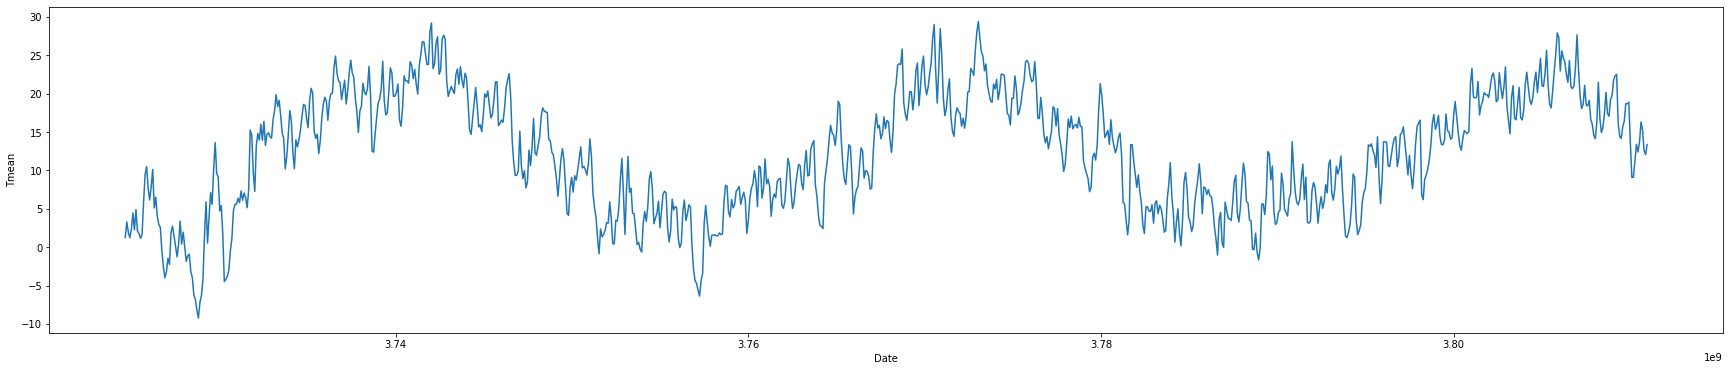

In [106]:
plt.figure(figsize=(30, 6))    
plt.plot(df["AbsoluteTime"][-1000:], df["Tmean"][-1000:])
plt.xlabel("Date")
plt.ylabel("Tmean")
plt.show()

In [107]:
K = 7
LIMIT = 100
OFFSET = 100

X, y = transofrm_seq_to_dataset(df['Tmean'].values, K)

test_time = df['AbsoluteTime'].values

Делим выборку на обучающую и тестовую в соотношении 3:1

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50221, 7, 1) (50221, 1)
(16741, 7, 1) (16741, 1)


In [109]:
def plot_prognoz_signal_chart_jena(preds, offset=OFFSET, limit=LIMIT): 
    plt.figure(figsize=(30, 6))
    plt.plot(test_time[-limit - offset:-offset], preds[-limit - offset:-offset], color='green')
    plt.plot(test_time[-limit - offset:-offset], y_test[-limit - offset - 1:-offset - 1], color='blue')
    plt.ylabel("Prognoz - Signal*")
    plt.xlabel("Time")
    plt.show()

In [110]:
def plot_error_chart_jena(preds, limit=LIMIT, offset=OFFSET):
    plt.figure(figsize=(10, 10))
    plt.plot(test_time[-limit - offset:-offset], preds[-limit - offset:-offset] - y_test[-limit - offset - 1:-offset - 1], linewidth=0.5)
    plt.ylabel("Error")
    plt.xlabel("Time")
    plt.ylim(-10, 10)
    plt.show()

Строим полносвязную нейронную сеть с тремя Dense слоями. Тестируем различные архитектуры и гиперпараметры и выбираем самую лучшую модель (прим. чтобы не перегружать notebook оставим только лучшую модель).

In [121]:
jena_seq_model = keras.models.Sequential([
    keras.layers.Dense(128, input_shape=(K, 1), activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Flatten(input_shape=(K, 32)),
    keras.layers.Dense(1, activation='linear'),
]) 


jena_seq_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mae')
jena_seq_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 7, 128)            256       
_________________________________________________________________
dense_51 (Dense)             (None, 7, 64)             8256      
_________________________________________________________________
dense_52 (Dense)             (None, 7, 32)             2080      
_________________________________________________________________
flatten_13 (Flatten)         (None, 224)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 225       
Total params: 10,817
Trainable params: 10,817
Non-trainable params: 0
_________________________________________________________________


In [122]:
jena_history = jena_seq_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.9857 - val_loss: 1.8332
Epoch 2/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8580 - val_loss: 1.8975
Epoch 3/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8556 - val_loss: 1.8344
Epoch 4/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8541 - val_loss: 1.8243
Epoch 5/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8518 - val_loss: 1.8155
Epoch 6/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8496 - val_loss: 1.8282
Epoch 7/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8456 - val_loss: 1.8179
Epoch 8/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8463 - val_loss: 1.8173
Epoch 9/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.8466 - val_loss: 1.8427
Epoch 10/10
1570/1570 [==============================] - 2s 1ms/step - loss: 1.842

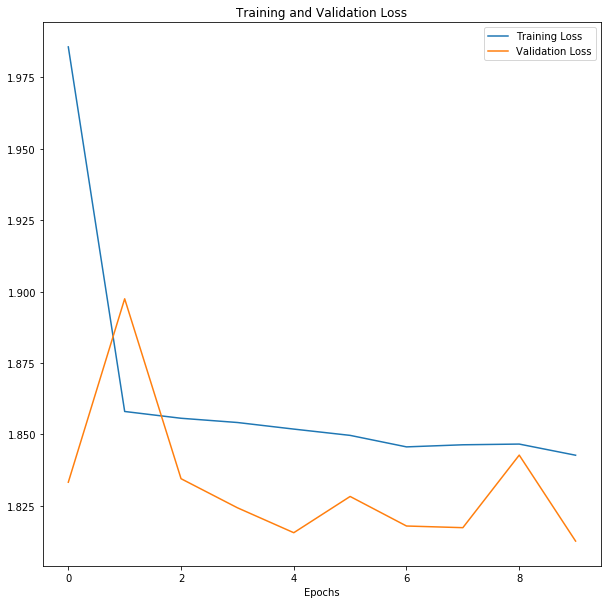

In [123]:
show_history(jena_history)

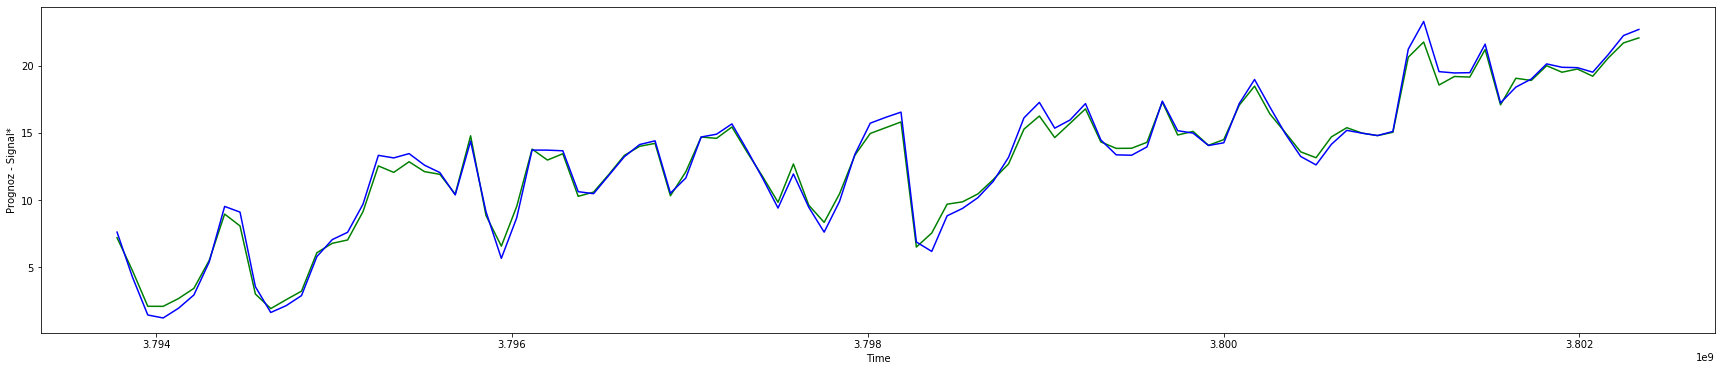

In [124]:
jena_seq_predictions = jena_seq_model.predict(X_test)
plot_prognoz_signal_chart_jena(jena_seq_predictions)

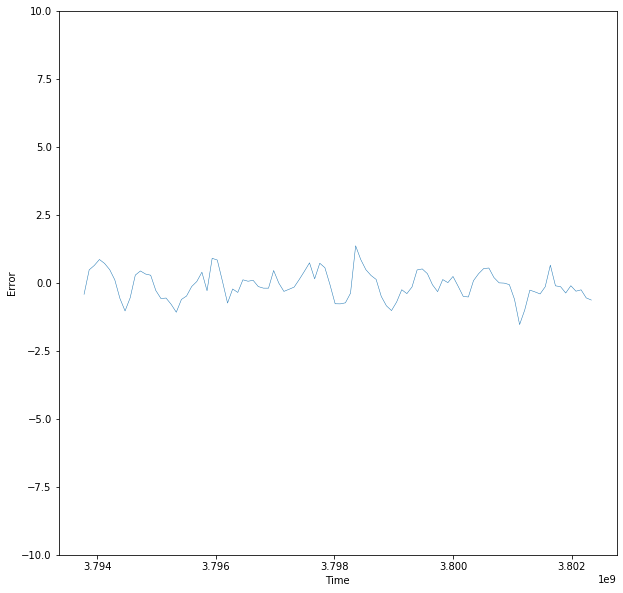

In [125]:
plot_error_chart_jena(jena_seq_predictions)

Строим рекуррентную сеть со 3-мя слоями GRU: по 64, 32 и 16 юнитов.

In [126]:
jena_gru_model = keras.models.Sequential([
    keras.layers.GRU(units=64, return_sequences=True, input_shape=(K, 1)),
    keras.layers.GRU(units=32, return_sequences=True),
    keras.layers.GRU(units=16),
    keras.layers.Dense(1),
]) 

jena_gru_model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mae')
jena_gru_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 7, 64)             12864     
_________________________________________________________________
gru_16 (GRU)                 (None, 7, 32)             9408      
_________________________________________________________________
gru_17 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 17        
Total params: 24,689
Trainable params: 24,689
Non-trainable params: 0
_________________________________________________________________


In [127]:
jena_gru_history = jena_gru_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1570/1570 [==============================] - 17s 11ms/step - loss: 2.7521 - val_loss: 2.0227
Epoch 2/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8770 - val_loss: 1.8913
Epoch 3/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8537 - val_loss: 1.8964
Epoch 4/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8498 - val_loss: 1.8395
Epoch 5/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8460 - val_loss: 1.9185
Epoch 6/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8462 - val_loss: 1.8312
Epoch 7/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8427 - val_loss: 1.8308
Epoch 8/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8383 - val_loss: 1.8480
Epoch 9/10
1570/1570 [==============================] - 16s 10ms/step - loss: 1.8365 - val_loss: 1.8345
Epoch 10/10
1570/1570 [==============================] - 16s 10m

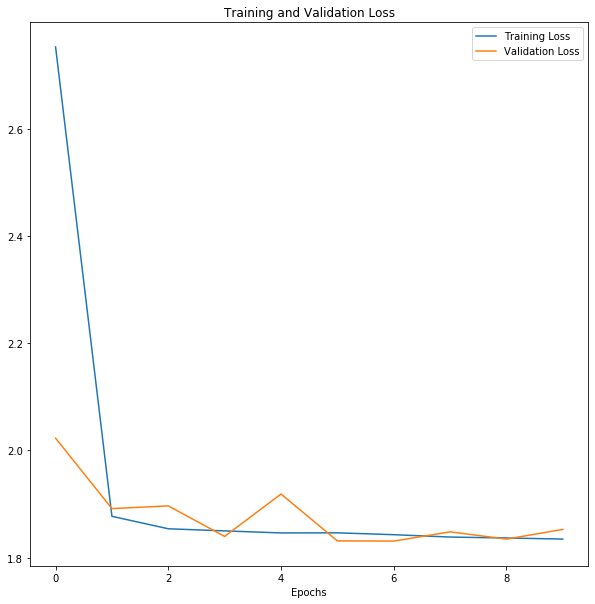

In [128]:
show_history(jena_gru_history)

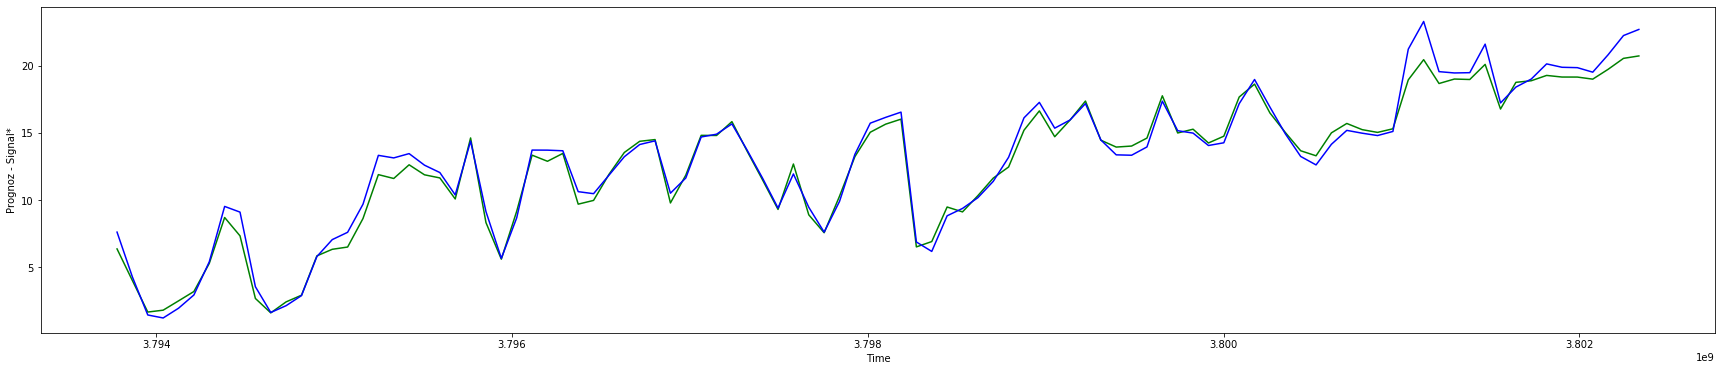

In [129]:
jena_gru_predictions = jena_gru_model.predict(X_test)
plot_prognoz_signal_chart_jena(jena_gru_predictions)

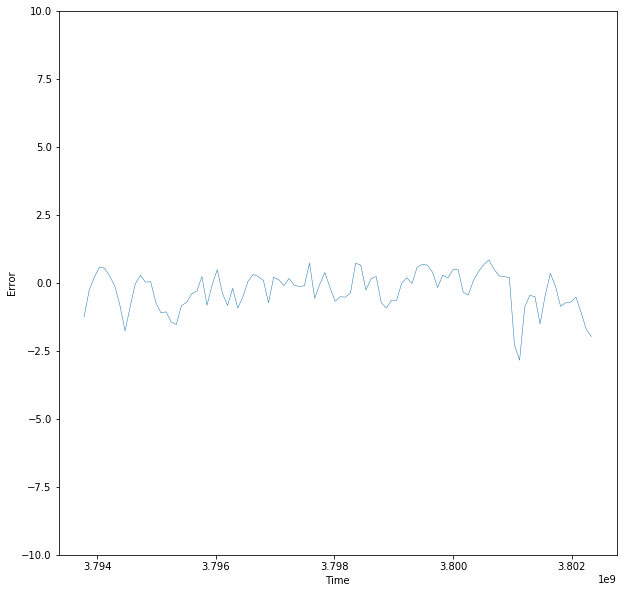

In [130]:
plot_error_chart_jena(jena_gru_predictions)

Как видим, разброс ошибки обоих моделей очень схож. Следовательно, они работают приблизительно с одинаковой эффективностью, хотя и полносвязная сеть показала себя чуть лучше.